Imports:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df_main = pd.read_csv('data/main.csv')
df_cat = pd.read_csv('data/categories.csv')
df_sim = pd.read_csv('data/similars.csv')
df_rev = pd.read_csv('data/reviews.csv')

In [3]:
nodes = pd.read_csv("data/nodes.csv")
links = pd.read_csv("data/links_type.csv")
bilinks = pd.read_csv("data/bilinks.csv")

Products-Customers relationships:

In [4]:
bilinks.head()

,Id,CId,Rating
0,1,110643,5.0
1,2,133242,5.0
2,3,3314,5.0
3,4,217326,4.0
4,5,7580,5.0


In [5]:
bilinks.Rating.unique()

array([5., 4., 1., 2., 3.])

- toode-toode erinevus 0 -> sarnasus 4 -> (1)
- toode-klient-toode erinevus 0 kuni 4 -> sarnasus 4 kuni 0 -> (1-0)

juh toode
- naaber 1: 0 -> 4 -> 0.5
- naaber 2: 1 -> 3 -> 0.375
- naaber 3: 3 -> 1 -> 0.125

In [6]:
print("Nbr of Products: ",bilinks.Id.nunique())
print("Nbr of Customers: ", bilinks.CId.nunique())

Nbr of Products:  410480
Nbr of Customers:  229313


We can see that each product has exactly one relation with one customer:

In [7]:
bilinks.groupby("Id").size().value_counts()

1    410480
dtype: int64

Customers may have lot of relations with different products:

In [8]:
counts = pd.DataFrame(bilinks.groupby("CId").size(),columns=["cnt"])
counts.cnt = counts.cnt.astype("int")

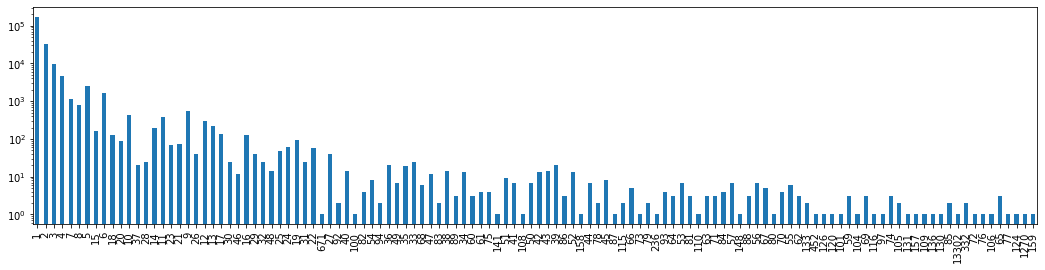

In [9]:
plt.figure(figsize=(18,4))
counts.cnt.value_counts(sort=False).plot(kind="bar")
plt.yscale("log")

## Idea of the Graph Neural Network
### Graph Convolutional Network
#### PinSAGE? Pins and Boards vs Items and Users vs Products and Customers

1. Collecting **neighbourhood** of item and presenting the item through its neighbourhood. -> We need to define the neighbourhood of item in bipartite graph.
2. Items **initial representation** should be embeddings created based on its features. -> We need to determine features for the items.
3. ...
4. PinSAGE creates embeddings based on item and its neighbourhood features.


Generate random product - find related customer - collect customer's all products
- Execute the following many times
- We can see the random product and its one hop neighbourhood products
- So, the neighbourhood of product would be the products of same related customer

In [10]:
random_product = np.random.choice(range(bilinks.Id.nunique()))
print("Random product: ", random_product)
related_customers = list(bilinks[bilinks.Id==random_product]["CId"])
for customer in related_customers:
    customer_products = bilinks[bilinks.CId==customer]
    print(customer_products)

Random product:  286285


In [11]:
random_product = np.random.choice(range(bilinks.Id.nunique()))
print("Random product: ", random_product)
related_customers = list(bilinks[bilinks.Id==random_product]["CId"])
for customer in related_customers:
    df = bilinks[(bilinks.CId==customer) & (bilinks.Id != random_product)]
    print(df)
    print(list(df.Id.values))
    print(list(df.Rating.values))

print(bilinks[bilinks.Id==random_product]["Rating"].mean())

Random product:  100098
           Id     CId  Rating
95309  123080  256337     3.0
[123080]
[3.0]
3.0


In [31]:
def find_neighbourhood(Product,bilinks=bilinks):
    """
    Finds 1-hop neighbours through common customer.
    """
    #if Product not in bilinks.Id.values: return
    Neighbourhood = []
    Similarities = []
    ProdRating = bilinks[bilinks.Id==Product]["Rating"].mean()
    related_customers = list(bilinks[bilinks.Id==Product]["CId"])
    for customer in related_customers:
        df = bilinks[(bilinks.CId==customer) & (bilinks.Id != Product)]
        Neighbourhood += list(df.Id.values)
        Similarities += list(4.0-np.abs(df.Rating.values-ProdRating))
    return Neighbourhood, Similarities

In [32]:
print(find_neighbourhood(370470))

([222290, 306430, 356428, 365115, 371825, 381584, 397849], [3.0, 2.0, 2.0, 2.0, 4.0, 4.0, 2.0])


In [14]:
one_hop_neighbourhood,_ = find_neighbourhood(137760)
two_hop_neighbourhood = []
for neighbour in one_hop_neighbourhood:
    print(neighbour)
    next_neighbours,_ = find_neighbourhood(neighbour)
    two_hop_neighbourhood += next_neighbours

two_hop_neighbourhood

229217


[137760]

In [15]:
links.head()

,from,to,conn_type
0,500600,1,BookBook
1,454888,2,BookBook
2,355935,7,MusicMusic
3,55461,8,BookBook
4,445607,8,BookBook


In [33]:
def get_neighbourhood(Product, links=links):
    """
    Gets all 1-hop neighbours (through common customer and direct neighbours).
    """
    Neighbourhood = []
    Similarities = []
    N, S = find_neighbourhood(Product)
    Neighbourhood += N
    Similarities += S
    Neighbourhood += list(links[links["from"]==Product]["to"]) 
    Neighbourhood += list(links[links["to"]==Product]["from"])
    n = len(Neighbourhood)-len(Similarities)
    if n>0: Similarities += n*[4.0]
    summa = np.maximum(sum(Similarities),0.1)
    Probabilities = list(np.array(Similarities)/summa)
    return Neighbourhood, Probabilities

In [34]:
N, S = get_neighbourhood(370470)
N, S

([222290, 306430, 356428, 365115, 371825, 381584, 397849],
 [0.15789473684210525,
  0.10526315789473684,
  0.10526315789473684,
  0.10526315789473684,
  0.21052631578947367,
  0.21052631578947367,
  0.10526315789473684])

In [18]:
bilinks[bilinks.Id==363401]

,Id,CId,Rating


In [19]:
random_product = np.random.choice(range(bilinks.Id.nunique()))
print("Random product: ", random_product)
one_hop,_ = get_neighbourhood(random_product)
print("1-hop neighbourhood: ", one_hop)
two_hop = []
for neighbour in one_hop:
    N, _ = get_neighbourhood(neighbour)
    two_hop += N
print("2-hop neighbourhood: ", two_hop)
# three_hop = []
# for neighbour in two_hop:
#     N, _ = get_neighbourhood(neighbour)
#     three_hop += N
# print("3-hop neighbourhood: ", three_hop)

Random product:  366931
1-hop neighbourhood:  [94599, 117273, 172177, 195956, 242411, 243669, 248775, 328520, 345921, 362785, 369982, 413886, 425925, 434027, 469864, 189234]
2-hop neighbourhood:  [117273, 172177, 195956, 242411, 243669, 248775, 328520, 345921, 362785, 366931, 369982, 413886, 425925, 434027, 469864, 156091, 243753, 94599, 172177, 195956, 242411, 243669, 248775, 328520, 345921, 362785, 366931, 369982, 413886, 425925, 434027, 469864, 94599, 117273, 195956, 242411, 243669, 248775, 328520, 345921, 362785, 366931, 369982, 413886, 425925, 434027, 469864, 94599, 117273, 172177, 242411, 243669, 248775, 328520, 345921, 362785, 366931, 369982, 413886, 425925, 434027, 469864, 94599, 117273, 172177, 195956, 243669, 248775, 328520, 345921, 362785, 366931, 369982, 413886, 425925, 434027, 469864, 212237, 212237, 94599, 117273, 172177, 195956, 242411, 248775, 328520, 345921, 362785, 366931, 369982, 413886, 425925, 434027, 469864, 281127, 94599, 117273, 172177, 195956, 242411, 243669, 3

In [20]:
find_neighbourhood(316872)

([], [])

In [21]:
def get_receptive_field(Product, K=2):
    Neighbourhood,Probabilities = get_neighbourhood(Product)
    if len(Neighbourhood)>0: 
        Field = list(np.random.choice(Neighbourhood,size=K,replace=True,p=Probabilities))
        return Field
    else:
        return None

In [22]:
get_receptive_field(309577,1)[0]

391714

In [23]:
def generate_random_walk(Product, H=5):
    random_walk = [Product]
    for hop in range(H):
        step = get_receptive_field(random_walk[hop],1)
        if step != None: random_walk.append(step[0])
        else: break
    return random_walk[1:]

In [24]:
bilinks[(bilinks.Id==11945) | (bilinks.Id==106116)]

,Id,CId,Rating
9665,11945,68022,5.0
82877,106116,149342,5.0


In [25]:
get_neighbourhood(11945)

([106116], [1.0])

In [26]:
generate_random_walk(11945)

[106116, 11945, 106116, 11945, 106116]

In [27]:
random_product = np.random.choice(range(bilinks.Id.nunique()))
print("Random product: ", random_product)
generate_random_walk(random_product,H=7)

Random product:  224507


[15469, 349556, 15469, 224507, 15469, 224507, 15469]

In [28]:
def L1_norm(dictionary):
    s = sum(list(dictionary.values()))
    N = {k: v/s for k, v in sorted(dictionary.items(), key=lambda item: item[1],reverse=True)}
    return N

In [29]:
def importance_pooling(Product,T):
    Neighbourhood = {}
    for times in range(T):
        collect = generate_random_walk(Product,H=T)
        for neighbour in collect:
            if neighbour in Neighbourhood: Neighbourhood[neighbour] += 1
            else: Neighbourhood[neighbour] = 1
    Neighbourhood = L1_norm(Neighbourhood)
    Neighbourhood = dict(list(Neighbourhood.items())[:T])
    return Neighbourhood

In [30]:
N = importance_pooling(373618,T=10)
print(N)

{373631: 0.12, 373618: 0.06, 82902: 0.05, 441095: 0.03, 262152: 0.02, 387378: 0.02, 30023: 0.02, 423643: 0.02, 141290: 0.02, 66486: 0.02}


### Features

In [38]:
nodes.head()

,Id,ASIN,Title,Group,Salesrank,NbrOfSimilar,NbrOfCategories,TotalReviews,Downloaded,AvgRating
0,1,0827229534,Patterns of Preaching: A Sermon Sampler,Book,396585,5,2,2,2,5.0
1,2,0738700797,Candlemas: Feast of Flames,Book,168596,5,2,12,12,4.5
2,3,0486287785,World War II Allied Fighter Planes Trading Cards,Book,1270652,0,1,1,1,5.0
3,4,0842328327,Life Application Bible Commentary: 1 and 2 Tim...,Book,631289,5,5,1,1,4.0
4,5,1577943082,Prayers That Avail Much for Business: Executive,Book,455160,5,2,0,0,0.0


Group, Salesrank, AvgRating

<AxesSubplot:>

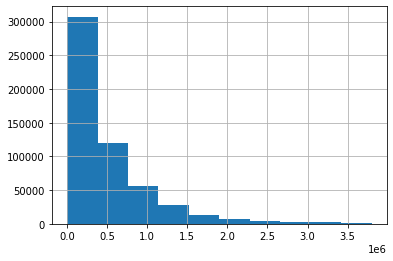

In [39]:
nodes.Salesrank.hist()

In [40]:
df_cat = pd.read_csv('data/categories.csv')
df_cat.head()

,Id,ASIN,L1,L2,L3,L4
0,1,0827229534,Books[283155],Subjects[1000],Religion & Spirituality[22],Christianity[12290]
1,1,0827229534,Books[283155],Subjects[1000],Religion & Spirituality[22],Christianity[12290]
2,2,0738700797,Books[283155],Subjects[1000],Religion & Spirituality[22],Earth-Based Religions[12472]
3,2,0738700797,Books[283155],Subjects[1000],Religion & Spirituality[22],Earth-Based Religions[12472]
4,3,0486287785,Books[283155],Subjects[1000],Home & Garden[48],Crafts & Hobbies[5126]


In [41]:
df_cat.drop("ASIN",axis=1,inplace=True)
df_cat

,Id,L1,L2,L3,L4
0,1,Books[283155],Subjects[1000],Religion & Spirituality[22],Christianity[12290]
1,1,Books[283155],Subjects[1000],Religion & Spirituality[22],Christianity[12290]
2,2,Books[283155],Subjects[1000],Religion & Spirituality[22],Earth-Based Religions[12472]
3,2,Books[283155],Subjects[1000],Religion & Spirituality[22],Earth-Based Religions[12472]
4,3,Books[283155],Subjects[1000],Home & Garden[48],Crafts & Hobbies[5126]
...,...,...,...,...,...
2538464,548551,Music[5174],Styles[301668],Broadway & Vocalists[265640],Classic Vocalists[67178]
2538465,548551,Music[5174],Styles[301668],Broadway & Vocalists[265640],Traditional Vocal Pop[513060]
2538466,548551,Music[5174],Styles[301668],Pop[37],Vocal Pop[406646]
2538467,548551,Music[5174],Styles[301668],Pop[37],Vocal Pop[406646]


In [42]:
df_cat.drop_duplicates(inplace=True)
df_cat.reset_index(drop=True,inplace=True)
df_cat

,Id,L1,L2,L3,L4
0,1,Books[283155],Subjects[1000],Religion & Spirituality[22],Christianity[12290]
1,2,Books[283155],Subjects[1000],Religion & Spirituality[22],Earth-Based Religions[12472]
2,3,Books[283155],Subjects[1000],Home & Garden[48],Crafts & Hobbies[5126]
3,4,Books[283155],Subjects[1000],Religion & Spirituality[22],Christianity[12290]
4,4,Books[283155],Subjects[1000],Religion & Spirituality[22],Bible & Other Sacred Texts[12056]
...,...,...,...,...,...
1760510,548551,Music[5174],Styles[301668],Miscellaneous[35],Nostalgia[67175]
1760511,548551,Music[5174],Styles[301668],Broadway & Vocalists[265640],Classic Vocalists[67178]
1760512,548551,Music[5174],Styles[301668],Broadway & Vocalists[265640],Traditional Vocal Pop[513060]
1760513,548551,Music[5174],Styles[301668],Pop[37],Vocal Pop[406646]


In [ ]:
df_cat["Category"] = df_cat.apply(lambda row: str(row["L1"])+str(row["L2"])+str(row["L3"])+str(row["L4"]),axis=1)
df_cat.head()

In [ ]:
df_categories = df_cat[["Category"]].drop_duplicates()
df_categories.reset_index(drop=True,inplace=True)
df_categories.reset_index(inplace=True)
df_categories.columns = ["CatId","Category"]
df_categories.set_index("Category",inplace=True)
df_categories.head()

,CatId
Category,
Books[283155] Subjects[1000] Religion & Spirituality[22] Christianity[12290],0
Books[283155] Subjects[1000] Religion & Spirituality[22] Earth-Based Religions[12472],1
Books[283155] Subjects[1000] Home & Garden[48] Crafts & Hobbies[5126],2
Books[283155] Subjects[1000] Religion & Spirituality[22] Bible & Other Sacred Texts[12056],3
Books[283155] Subjects[1000] Arts & Photography[1] Photography[2020],4


In [ ]:
df_cat.head()

,Id,L1,L2,L3,L4
Category,,,,,
Books[283155] Subjects[1000] Religion & Spirituality[22] Christianity[12290],1,Books[283155],Subjects[1000],Religion & Spirituality[22],Christianity[12290]
Books[283155] Subjects[1000] Religion & Spirituality[22] Earth-Based Religions[12472],2,Books[283155],Subjects[1000],Religion & Spirituality[22],Earth-Based Religions[12472]
Books[283155] Subjects[1000] Home & Garden[48] Crafts & Hobbies[5126],3,Books[283155],Subjects[1000],Home & Garden[48],Crafts & Hobbies[5126]
Books[283155] Subjects[1000] Religion & Spirituality[22] Christianity[12290],4,Books[283155],Subjects[1000],Religion & Spirituality[22],Christianity[12290]
Books[283155] Subjects[1000] Religion & Spirituality[22] Bible & Other Sacred Texts[12056],4,Books[283155],Subjects[1000],Religion & Spirituality[22],Bible & Other Sacred Texts[12056]


In [ ]:
# df_cat.set_index("Category",inplace=True)
# df_cat = df_cat.join(df_categories)
df_cat.reset_index(drop=True,inplace=True)
df_cat

,Id,L1,L2,L3,L4,CatId
0,2323,Books[283155],By Publisher[298531],"""OReilly[69860]""",Internet Security[69889],797
1,13716,Books[283155],By Publisher[298531],"""OReilly[69860]""",Internet Security[69889],797
2,24851,Books[283155],By Publisher[298531],"""OReilly[69860]""",Internet Security[69889],797
3,37205,Books[283155],By Publisher[298531],"""OReilly[69860]""",Internet Security[69889],797
4,64363,Books[283155],By Publisher[298531],"""OReilly[69860]""",Internet Security[69889],797
...,...,...,...,...,...,...
1760510,536720,a,NaN,NaN,NaN,109
1760511,537077,a,NaN,NaN,NaN,109
1760512,537275,a,NaN,NaN,NaN,109
1760513,542506,a,NaN,NaN,NaN,109


In [ ]:
df_cat.L1.unique()

array(['Books[283155]', 'Music[5174]', 'Sports & Outdoor[3375251]',
       'Sportsrus.com[3489201]', '[1055398]', '[1064952]', '[139452]',
       '[171280]', '[172282]', '[229220]', '[229534]', '[265523]',
       '[468642]', '[540744]', '[700060]', 'a'], dtype=object)

In [ ]:
df_cat = df_cat[df_cat.L1!='a']

In [ ]:
df_cat.isnull().sum()

Id          0
L1          0
L2          0
L3         18
L4       7932
CatId       0
dtype: int64

In [ ]:
df_cat["count"]=1

/var/folders/hk/kbn1q_sj4jz4lh0m7x05vff80000gn/T/ipykernel_26611/2874000793.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cat["count"]=1


In [ ]:
df_cat.head()

,Id,L1,L2,L3,L4,CatId,count
0,2323,Books[283155],By Publisher[298531],"""OReilly[69860]""",Internet Security[69889],797,1
1,13716,Books[283155],By Publisher[298531],"""OReilly[69860]""",Internet Security[69889],797,1
2,24851,Books[283155],By Publisher[298531],"""OReilly[69860]""",Internet Security[69889],797,1
3,37205,Books[283155],By Publisher[298531],"""OReilly[69860]""",Internet Security[69889],797,1
4,64363,Books[283155],By Publisher[298531],"""OReilly[69860]""",Internet Security[69889],797,1


In [ ]:
#cat_vocab = 
pd.pivot_table(data=df_cat,index="Id",columns="CatId",values="count",aggfunc=np.sum,fill_value=0)

CatId,0,1,2,3,4,5,6,7,8,9,...,1245,1246,1247,1248,1249,1250,1251,1252,1253,1254
Id,,,,,,,,,,,,,,,,,,,,,
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
548547,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
548548,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
548549,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df_L1_2 = df_cat[["L1","L2"]].drop_duplicates()
df_L1_2.columns = ["from","to"]
df_L2_3 = df_cat[["L2","L3"]].drop_duplicates()
df_L2_3.columns = ["from","to"]
df_L3_4 = df_cat[["L3","L4"]].drop_duplicates()
df_L3_4.columns = ["from","to"]
df_cat_connections = pd.concat([df_L1_2,df_L2_3,df_L3_4],axis=0)

In [ ]:
df_cat_connections.shape

(1461, 2)

In [ ]:
df_cat_connections.head()

,from,to
0,Books[283155],Subjects[1000]
16,[172282],Categories[493964]
17,Music[5174],Styles[301668]
19,Music[5174],Specialty Stores[468040]
31,Books[283155],Specialty Stores[504360]


In [ ]:
import networkx as nx 

G = nx.from_pandas_edgelist(df_cat_connections, source='from', target='to')

In [ ]:
nx.info(G)

'Graph with 1424 nodes and 1460 edges'

In [ ]:
import graphmethods as gr

gr.net_prop_dict(G)

{'no_of_nodes': 1424,
 'no_of_edges': 1460,
 'transitivity': 0.00025870989996550536,
 'average_clustering': 3.327853432057854e-05,
 'edge_density': 0.0014410132099457547,
 'average_degree': 2.050561797752809,
 'total_triangles': 3,
 'number_connected_components': 9}

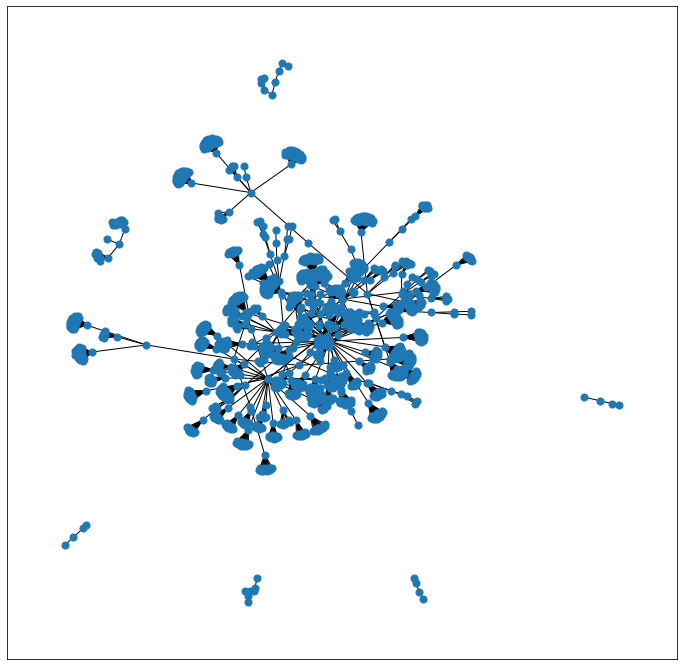

In [ ]:
plt.figure(figsize=(12,12))
nx.draw_networkx(G,pos=nx.spring_layout(G), with_labels=False,node_size=50)

In [ ]:
nx.is_tree(G)

False

In [20]:
nx.is_forest(G)

False